# 🌾 **Global Wheat Detection: KerasCV YOLOv8 Inference**

## I. Overview
This notebook outlines the **Inference Pipeline** for the Global Wheat Detection competition. It utilizes a fine-tuned **YOLOv8** model built using the **KerasCV** library. The goal is to accurately localize wheat heads in agricultural images, even under varying lighting conditions and growth stages.

To maximize predictive performance and robustness, this pipeline incorporates **Test Time Augmentation (TTA)** and **Weighted Boxes Fusion (WBF)**. TTA generates predictions on multiple augmented versions of the same image (e.g., flips), and WBF consolidates these predictions into a single, more accurate set of bounding boxes.

## II. Training Methodology (Recap)
The model used in this inference pipeline was trained using a **Stratified Optimization Strategy** in a separate notebook. Key highlights of the training process include:
* **Architecture:** KerasCV YOLOv8 Backbones.
* **Phased Training:** 1.  **Warmup:** Stabilizing weights with a gradual learning rate ramp-up.
    2.  **Mid-Tune:** Primary training phase with cosine decay.
    3.  **Fine-Tune:** Low learning rate refinement for maximum precision.

## III. Project Resources
* **Training Notebook:** [🌾 KerasCV YOLOv8 Fine-Tuning](https://www.kaggle.com/code/amirmohamadaskari/wheat-detection-yolov8-fine-tuning) - *See how this model was trained.*
* **Trained Model:** [Wheat Detection YOLOv8 Model](https://www.kaggle.com/models/amirmohamadaskari/wheat-detection) - *Download or use the fine-tuned weights.*
* **Dataset:** [Global Wheat Detection Data](https://www.kaggle.com/competitions/global-wheat-detection/data) - *Competition dataset.*

---

##  IV. Pipeline Summary
1.  **Environment Setup:** Loading offline utility libraries (e.g., `ensemble_boxes`).
2.  **Hardware Initialization:** Detecting TPUs/GPUs and setting mixed-precision policies.
3.  **Model Loading:** Importing the saved KerasCV model with custom objects.
4.  **Inference Utilities:** Defining functions for TTA and Box Fusion.
5.  **Prediction Loop:** Iterating through test images and generating submissions.

## **Section 1. Environment Setup & Library Imports**

In this section, we import the necessary core libraries for image processing (`cv2`), numerical operations (`numpy`), and deep learning (`tensorflow`, `keras_cv`).

**Note on Offline Inference:**
Since internet access is often disabled during Kaggle code competitions, external libraries like `ensemble_boxes` (used for WBF) must be loaded from local datasets.

---

### **1.1 Importing Required Libraries**
We begin by importing all necessary packages used throughout the inference notebook:

- **TensorFlow / KerasCV** — model loading & inference  
- **OpenCV** — image pre-processing  
- **NumPy / Pandas** — data manipulation  
- **Matplotlib** — visualization  
- **ensemble_boxes** — Weighted Boxes Fusion for merging multiple TTA predictions  

TensorFlow logging is suppressed so the notebook output stays clean.

In [5]:
import ast
import cv2
import keras_cv
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import tensorflow as tf
# Suppress TensorFlow warning messages for cleaner output
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

### **1.2 Listing Available Compute Devices**
We print all detected logical devices (CPU / GPU / TPU).  
This helps verify what kind of accelerator is provided by the Kaggle environment.

In [12]:
# Check available devices for verification
print("Available devices: \n")
for device in tf.config.list_logical_devices():
    print(device.name, device.device_type)

Available devices: 

/device:CPU:0 CPU
/device:GPU:0 GPU


I0000 00:00:1763317942.531370      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


### **1.3 Selecting the Optimal Distribution Strategy**
A helper function automatically selects the best TensorFlow strategy:

1. **TPU** (fastest for object detection on Kaggle)  
2. **GPU** (MirroredStrategy for multi-GPU)  
3. **CPU** as fallback  

The chosen strategy ensures performance and compatibility when running the model.

In [13]:
def get_strategy():
    """
    Detects and returns the best TensorFlow distribution strategy.
    - TPUStrategy for TPU(s)
    - MirroredStrategy for GPU(s)
    - Default strategy for CPU
    """
    try:
        # Try TPU first
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        print("Using TPU strategy:", type(strategy).__name__)
    except Exception:
        # If TPU not available, try GPU
        gpus = tf.config.list_physical_devices('GPU')
        if gpus:
            strategy = tf.distribute.MirroredStrategy()
            print("Using GPU strategy:", type(strategy).__name__)
        else:
            # Fallback CPU
            strategy = tf.distribute.get_strategy()
            print("No TPU/GPU found. Using CPU strategy:", type(strategy).__name__)

    print("REPLICAS:", strategy.num_replicas_in_sync)
    return strategy

# Call it
strategy = get_strategy()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Using GPU strategy: MirroredStrategy
REPLICAS: 1


---
### **1.4 Loading Offline `ensemble_boxes` Package**
Kaggle competition environments do not allow internet installation.  
Therefore, the project includes an **isolated version** of `ensemble_boxes`, which is manually appended to `sys.path`.

This package provides **Weighted Boxes Fusion (WBF)** used later for combining predictions across TTA augmentations.


In [41]:
# --- Configuration for Offline Libraries ---
# Path to the dataset containing the 'ensemble_boxes' library
PACKAGE_DIR = '/kaggle/input/wheat-detection-ensemble-boxes/isolated_ensemble_boxes/' 
if PACKAGE_DIR not in sys.path:
    sys.path.append(PACKAGE_DIR)

print(f"Added isolated package path to sys.path: {PACKAGE_DIR}")

import ensemble_boxes
print("✅ ensemble_boxes imported successfully.")

Added isolated package path to sys.path: /kaggle/input/wheat-detection-ensemble-boxes/isolated_ensemble_boxes/
✅ ensemble_boxes imported successfully.


---
### **1.5 Verifying WBF Import**
We attempt to import `weighted_boxes_fusion`.  
If not available, a clear warning is shown so the user understands the missing dependency.


In [42]:
# Try importing the WBF function to ensure the library is loaded correctly
try:
    from ensemble_boxes import weighted_boxes_fusion
except ImportError:
    print("WARNING: The 'ensemble_boxes' library is required for WBF.")
    print("Please run: pip install ensemble-boxes")
    # Placeholder to prevent crash, you must install the library to proceed
    weighted_boxes_fusion = None 

## **Section 2. Global Configuration & Data Paths**

Here we define the hyperparameters for inference, such as image size, confidence thresholds, and Intersection over Union (IoU) thresholds.

* **`CONF_THRESHOLD`**: Only predictions with confidence above this value are kept.
* **`IOU_THRESHOLD`**: Used in Non-Max Suppression (NMS) or WBF to decide when boxes overlap enough to be merged.
* **`NUM_TTA`**: The number of augmentations (e.g., flips/rotations) to apply per image.

In [85]:
# --- Inference Hyperparameters ---
AUTO = tf.data.AUTOTUNE  # Auto from TensorFlow
IMG_SIZE = (1024, 1024)  # Input size for the YOLOv8 model
NUM_CLASSES = 1          # Wheat heads
NUM_TTA = 8              # Number of Test Time Augmentations
CONF_THRESHOLD = 0.40    # Minimum confidence score to keep a box
IOU_THRESHOLD = 0.50     # IoU threshold for Weighted Boxes Fusion
BATCH_SIZE_PER_REPLICA = 1
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

# --- Data & Model Paths ---
# Root directory for competition data
DATA_DIR = '/kaggle/input/global-wheat-detection' 
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')
CSV_PATH = os.path.join(DATA_DIR, 'train.csv')

# Path to the fine-tuned KerasCV model (ensure this matches your uploaded model dataset)
MODEL_DIR = '/kaggle/input/wheat-detection/keras/warmup/3/finetune_best_model.keras'

print(f"Global Batch size: {BATCH_SIZE}")

Global Batch size: 1


## **Section 3. Model Loading**

We load the fine-tuned YOLOv8 model within the distribution strategy scope.

**Crucial Step:**
Because `KerasCV` models use custom layers and backbones (like `YOLOV8Detector` and `YOLOV8Backbone`), we must pass these in the `custom_objects` dictionary when loading the model. This allows TensorFlow to reconstruct the architecture correctly.

In [16]:
with strategy.scope():
    print("Loading model ...")
    # Load the model providing necessary custom objects from KerasCV
    yolo_model = tf.keras.models.load_model(MODEL_DIR,
            custom_objects = {
                'YOLOV8Detector': keras_cv.models.YOLOV8Detector,
                'YOLOV8Backbone': keras_cv.models.YOLOV8Backbone
            }
    )
    print("Model loaded successfully. Ready for Visualization and Test Time !")

Loading model ...


/usr/local/lib/python3.11/dist-packages/keras/src/saving/serialization_lib.py:734: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)


Model loaded successfully. Ready for Visualization and Test Time !


## **Section 4. Data Preparation & Basic Visualization Utilities**

This section handles the preprocessing of bounding-box annotations and provides helper
functions for visualizing sample images from the **training** and **test** datasets.  
These steps are not part of inference preprocessing — they are only used for validation, inspection,
and manual quality checks.

---

### **4.1 — Load CSV & Expand Bounding Boxes**

The Kaggle Wheat Detection dataset stores bounding boxes as Python-like string lists  
(e.g., `"[x, y, w, h]"`).  
We convert them into actual lists using `ast.literal_eval`, then expand them to  
the more convenient `x_min, y_min, x_max, y_max` format for visualization.

In [33]:
df = pd.read_csv(CSV_PATH)
# Convert the string representation of the list in 'bbox' column to an actual list
df['bbox'] = df['bbox'].apply(ast.literal_eval)
# Extract coordinates from the list: [x_min, y_min, x_max, y_max]
df['x_min'] = df['bbox'].apply(lambda b: b[0])
df['y_min'] = df['bbox'].apply(lambda b: b[1])
df['x_max'] = df['bbox'].apply(lambda b: b[0] + b[2])
df['y_max'] = df['bbox'].apply(lambda b: b[1] + b[3])

### **4.2 — Visualize Random Training Images with Ground-Truth Boxes**  
This function randomly selects images from the training directory, loads them using OpenCV, and overlays all ground-truth bounding boxes belonging to that image.  
Useful for verifying annotation quality before training.


In [20]:
def show_images_with_bboxes(df, image_dir, nrows, ncols):
    # Pick random images from the train dir
    files = os.listdir(image_dir)
    fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))

    for ax, fname in zip(axs.flatten(), files):
        image_id = fname.replace('.jpg', '')

        # Load image
        img_path = os.path.join(image_dir, fname)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Get bboxes if exists
        if image_id in df['image_id'].values:
            bboxes = df[df['image_id'] == image_id][['x_min', 'y_min', 'x_max', 'y_max']].values
            for (x_min, y_min, x_max, y_max) in bboxes:
                start_point = (int(x_min), int(y_min))
                end_point = (int(x_max), int(y_max))
                color = (255, 0, 0)
                thickness = 2
                cv2.rectangle(img, start_point, end_point, color, thickness)

        # Show image
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(fname, fontsize=8)
        
    plt.tight_layout()
    plt.show()

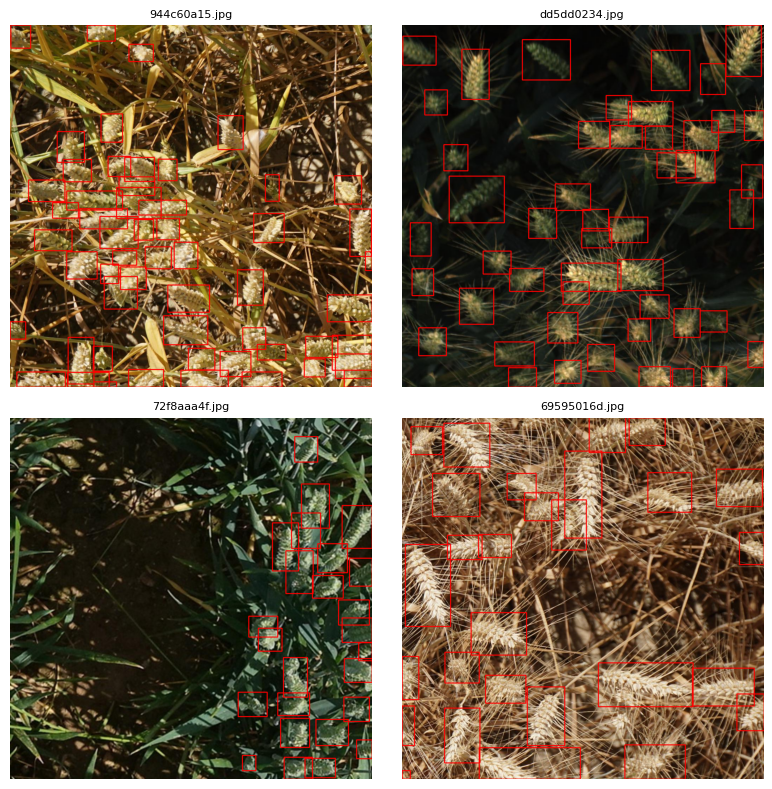

In [21]:
show_images_with_bboxes(df, TRAIN_DIR, 2, 2)

### **4.3 — Utility: Load a Single Image for Visualization**  
We define a helper function that loads and resizes a single image to the model’s expected input size.  
This is **not** a preprocessing pipeline for inference — it's only for visualization helper tools.


In [31]:
def load_single_image(image_path):
    """Loads and resizes a single image for prediction."""
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    return image

### **4.4 — Visualize Model Predictions on Test Images**  
This function loads a small batch of test images, runs YOLO model inference, filters out low-confidence predictions, and visualizes the results using `keras_cv.visualization.plot_bounding_box_gallery()`.  
This helps verify whether the model produces meaningful predictions before moving to full inference.


In [76]:
def detections(model, image_path, bounding_box_format="xyxy", 
                         confidence_threshold=CONF_THRESHOLD):
    files = os.listdir(image_path)[:4]
    paths = [os.path.join(image_path, f) for f in files]
    num_images = len(paths)

    image_list = [load_single_image(path) for path in paths]
    images = tf.stack(image_list)
    print(f"Loaded {num_images} images into a batch of shape {images.shape}")
    
    # Run model inference on the batch
    y_pred = model.predict(images)

    # y_pred is a dictionary: {'boxes': ..., 'confidence': ..., 'classes': ...}
    # Filter low-confidence boxes manually (since keras_cv.bounding_box has no filter)
    conf_mask = y_pred["confidence"] > confidence_threshold

    # Create filtered prediction dict
    y_pred_filtered = {
        "boxes": tf.ragged.boolean_mask(y_pred["boxes"], conf_mask),
        "classes": tf.ragged.boolean_mask(y_pred["classes"], conf_mask),
        "confidence": tf.ragged.boolean_mask(y_pred["confidence"], conf_mask),
    }

    # Visualize with KerasCV utility
    keras_cv.visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_pred=y_pred_filtered,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
    )

    return y_pred


Loaded 4 images into a batch of shape (4, 1024, 1024, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step


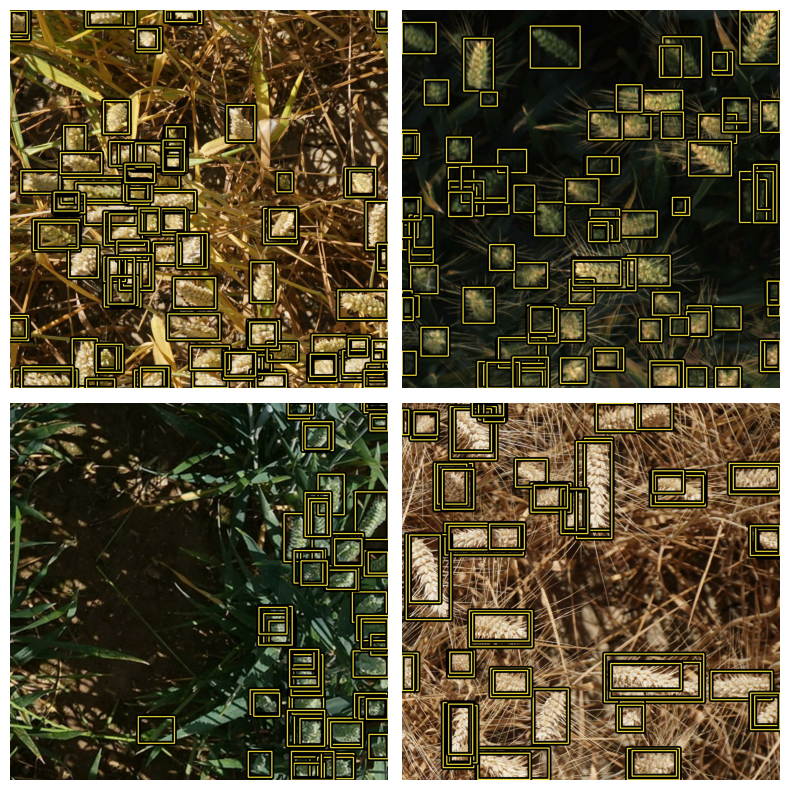

In [77]:
y_pred = detections(yolo_model, TRAIN_DIR, bounding_box_format="xyxy")

Also we can see what's the `Structure` of `Prediction` is like

In [78]:
print(y_pred)

{'boxes': array([[[ 2.53356812e+02,  2.45655243e+02,  3.23440613e+02,
          3.35981445e+02],
        [ 8.88664429e+02,  7.58276184e+02,  1.02374957e+03,
          8.38021729e+02],
        [ 5.87958435e+02,  2.58236572e+02,  6.63701416e+02,
          3.56009552e+02],
        ...,
        [ 9.90311584e+02, -2.61585712e-01,  1.02411646e+03,
          4.92757187e+01],
        [ 4.52816772e+02,  6.05965088e+02,  5.34871643e+02,
          6.99334167e+02],
        [ 6.49517151e+02,  8.45663940e+02,  7.21582825e+02,
          9.10112488e+02]],

       [[ 1.20509552e+02,  3.44718323e+02,  1.88062073e+02,
          4.13381714e+02],
        [ 3.59884216e+02,  5.20167969e+02,  4.41351044e+02,
          6.11344604e+02],
        [-9.56497192e-02,  3.32848663e+01,  9.24778748e+01,
          1.18969193e+02],
        ...,
        [ 7.26940735e+02,  8.33130859e+02,  7.76876343e+02,
          8.81262207e+02],
        [ 7.32337280e+02,  5.07880310e+02,  7.79931335e+02,
          5.56468140e+02],
     

Loaded 4 images into a batch of shape (4, 1024, 1024, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step


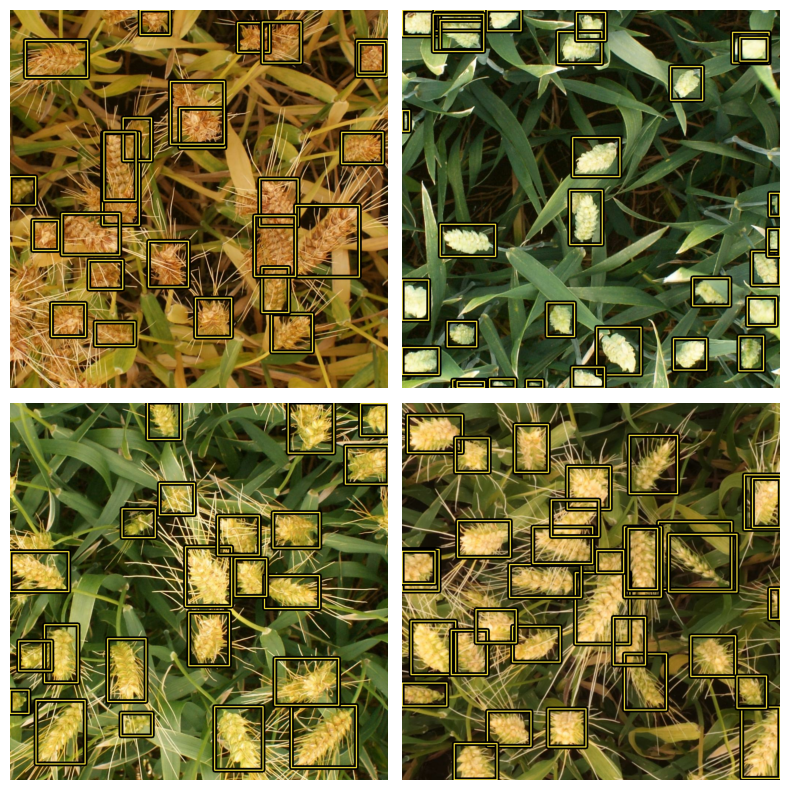

In [79]:
y_pred = detections(yolo_model, TEST_DIR)

##  Section 5. Test-Time Augmentation (TTA) and Box Coordinate Reversal

In object detection, **Test-Time Augmentation (TTA)** is a powerful technique where we run inference on multiple augmented versions of an image (e.g., flips, color jitter) and then convert all predictions back into the *original* coordinate system.

This is especially important for flips:
- A **horizontal flip** mirrors the image on the x-axis → bounding boxes must be reversed accordingly.
- A **vertical flip** mirrors the image on the y-axis → bounding boxes must also be reversed.

This section focuses on:
1. Applying deterministic augmentations (HFlip, VFlip).
2. Predicting with the model on each augmented image.
3. Reversing the predicted bounding boxes back to original image coordinates.
4. Verifying visually that the reversal logic is correct.


### **5.1 — Reverse Horizontal Flip (HFlip)**

A horizontal flip mirrors the image across the **vertical midline**, which inverts the x-coordinates:

- `xmin_new = image_width  - xmax_old`
- `xmax_new = image_width  - xmin_old`

Y-coordinates remain unchanged.

This subsection implements the exact mathematical reversal needed to convert horizontally-flipped predictions back into the original coordinate system.

In [50]:
def reverse_h_flip(boxes, image_width= IMG_SIZE[1]):
    """Reverses a horizontal flip for pixel-space [xmin, ymin, xmax, ymax] boxes."""
    xmin = image_width - boxes[:, 2]
    ymin = boxes[:, 1]
    xmax = image_width - boxes[:, 0]
    ymax = boxes[:, 3]
    return tf.stack([xmin, ymin, xmax, ymax], axis=-1)


### **5.2 — Reverse Vertical Flip (VFlip)**

A vertical flip mirrors the image across the **horizontal midline**, which inverts the y-coordinates:

- `ymin_new = image_height - ymax_old`
- `ymax_new = image_height - ymin_old`

X-coordinates remain unchanged.

This subsection provides the correct formula for restoring bounding boxes after vertical flipping.


In [51]:
def reverse_v_flip(boxes, image_height= IMG_SIZE[0]):
    """Reverses a vertical flip for normalized [xmin, ymin, xmax, ymax] boxes."""
    # ymin_new = 1 - ymax_old; ymax_new = 1 - ymin_old
    xmin = boxes[:, 0]     # Use xmin index (0)
    ymin = image_height - boxes[:, 3] # Use ymax index (3)
    xmax = boxes[:, 2]     # Use xmax index (2)
    ymax = image_height - boxes[:, 1] # Use ymin index (1)
    
    # Must stack in the original [xmin, ymin, xmax, ymax] order
    return tf.stack([xmin, ymin, xmax, ymax], axis=-1)

### **5.3 — Mild Color Jitter (Non-Geometric)**

Color jitter modifies pixel intensities but **does not affect spatial geometry**, so bounding boxes stay the same.

We apply light augmentations:
- Random Hue (±0.04)
- Random Contrast (0.85–1.15)
- Random Saturation (0.85–1.15)
- Random Brightness (±0.04)

These improve robustness to lighting variations without distorting object locations.


In [52]:
# Function to apply multiple, slightly random color/light transforms
def random_color_jitter(img):
    # Apply small random hue shift
    img = tf.image.random_hue(img, max_delta=0.04) 
    # Apply small random contrast
    img = tf.image.random_contrast(img, lower=0.85, upper=1.15) 
    # Apply small random saturation
    img = tf.image.random_saturation(img, lower=0.85, upper=1.15)
    # Apply small random brightness
    img = tf.image.random_brightness(img, max_delta=0.04)
    return img

### **5.4 — Predict & Filter Detections**

A reusable helper function that:

1. Expands the input image to a batch  
2. Runs `model.predict()`  
3. Filters boxes by confidence threshold  
4. Returns a RaggedTensor prediction dictionary:
   - `"boxes"`
   - `"classes"`
   - `"confidence"`

Used for:
- Original image prediction  
- Flipped image prediction  
- TTA inference pipelines  


In [68]:
test_img_path = os.path.join(TEST_DIR, os.listdir(TEST_DIR)[3])
test_img = load_single_image(test_img_path)

In [56]:
def predict_and_filter(model, image_tensor, conf_threshold):
    """
    Runs model prediction on a single image, filters results by confidence.
    
    Args:
        model: The trained Keras model.
        image_tensor: The input image (H, W, 3).
        conf_threshold: Minimum confidence score to keep a detection.
        
    Returns:
        dict: A dictionary of filtered predictions {"boxes", "classes", "confidence"}
              in KerasCV RaggedTensor format, with batch dimension [1, None, ...].
    """
    # Add batch dimension: [1, H, W, 3]
    input_tensor = tf.expand_dims(image_tensor, 0)
    
    # Predict
    y_pred = model.predict(input_tensor, verbose=0)

    # Filter by confidence
    conf_mask = y_pred["confidence"] > conf_threshold
    
    # Apply mask to all prediction components
    y_pred_filtered = {
        "boxes": tf.ragged.boolean_mask(y_pred["boxes"], conf_mask),
        "classes": tf.ragged.boolean_mask(y_pred["classes"], conf_mask),
        "confidence": tf.ragged.boolean_mask(y_pred["confidence"], conf_mask),
    }
    
    return y_pred_filtered

### **5.5 — Visualize Predictions**

A visualization utility that wraps  
`keras_cv.visualization.plot_bounding_box_gallery()`.

We use it to:
- Inspect original predictions  
- Inspect flip-space predictions  
- Inspect reversed predictions on the original image  

This is essential to verify that flip reversals align with ground truth spatial structure.


In [57]:
def visualize_prediction(image_tensor, predictions, title, **kwargs):
    """
    Visualizes the prediction on the given image tensor.
    
    Args:
        image_tensor: The image to plot on (H, W, 3).
        predictions: The prediction dictionary from predict_and_filter.
        title: Title to print before visualization.
        **kwargs: Optional keyword arguments for plot_bounding_box_gallery.
    """
    print(f"\n--- {title} ---")
    
    keras_cv.visualization.plot_bounding_box_gallery(
        tf.expand_dims(image_tensor, 0),
        value_range=(0, 255),
        bounding_box_format="xyxy",
        y_pred=predictions,
        scale=4,
        rows=1,
        cols=1,
        show=True,
        font_scale=0.7,
        **kwargs
    )
    print(f"✅ {title} visualized.")

### **5.6 — Step 1 — Original Image Prediction**

We begin with the baseline:  
Run inference on the unaltered image to produce reference-coordinate bounding boxes.

All TTA-corrected boxes are later compared to this reference.


--- Original Prediction ---


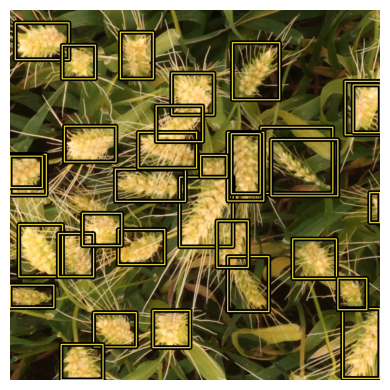

✅ Original Prediction visualized.


In [58]:
# --- STEP 1: Original Image Prediction ---
y_pred_original = predict_and_filter(
    yolo_model, 
    test_img, 
    CONF_THRESHOLD
)

visualize_prediction(
    test_img, 
    y_pred_original, 
    "Original Prediction"
)

### **5.6 — Step 2 — Prediction on Vertically Flipped Image**

We flip the input vertically and run the model again.

Important:
- Predictions now exist **in flipped coordinate space**
- Boxes must not be used directly
- They must first be corrected (next step)



--- Flipped Image Prediction ---


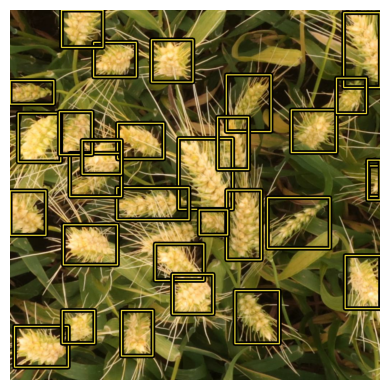

✅ Flipped Image Prediction visualized.


In [61]:
# --- STEP 2: Vertical Flip, Predict, and Visualize Flipped ---
vflipped_img = tf.image.flip_up_down(test_img)

y_pred_flip = predict_and_filter(
    yolo_model, 
    vflipped_img, 
    CONF_THRESHOLD
)

visualize_prediction(
    vflipped_img, 
    y_pred_flip, 
    "Flipped Image Prediction"
)

### **5.6 — Step 3 — Reverse Vertical Flip & Visualize on Original Image**

We take vertical-flip predictions and mathematically map them back to the original coordinate system using the reversal formula.

Then we visualize these corrected boxes **on the original image**.

This final step verifies:
- Box reversal logic is correct  
- Predictions align normally after TTA  
- No shift/offset/misalignment occurs  



Reversing flipped boxes to original coordinates...

--- Reversed Flipped Boxes on Original Image ---


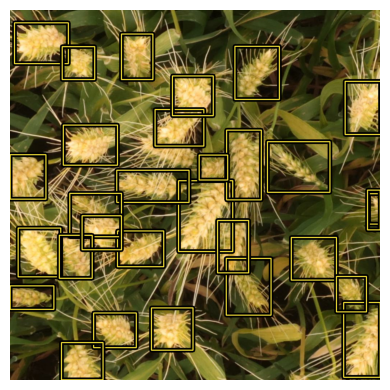

✅ Reversed Flipped Boxes on Original Image visualized.


In [62]:
# --- STEP 3: Reverse Boxes and Visualize on Original Image ---
print("\nReversing flipped boxes to original coordinates...")

# Extract boxes from the filtered RaggedTensor (get the dense tensor at index 0)
boxes_augmented = y_pred_flip["boxes"][0] 

# Reverse it
boxes_reversed = reverse_v_flip(boxes_augmented)

# Reformat the reversed boxes into the prediction dictionary for plotting
y_pred_reversed = {
    "boxes": tf.RaggedTensor.from_tensor(tf.expand_dims(boxes_reversed, axis=0)),
    "classes": y_pred_flip["classes"],
    "confidence": y_pred_flip["confidence"],
}

visualize_prediction(
    test_img, 
    y_pred_reversed, 
    "Reversed Flipped Boxes on Original Image"
)

---
## Section **6 — TTA Sequences & TTA Aggregation Pipeline**

This section defines the complete TTA (Test-Time Augmentation) pipeline.  
TTA improves detection robustness by running multiple augmented versions of the same input image through the model and then aggregating the predictions back into the original coordinate system.

We define:
- A set of **TTA sequences** (image augmentation + reverse-mapping function)
- A **TTA engine** that:
  1. Applies each augmentation  
  2. Runs inference  
  3. Reverses bounding boxes  
  4. Aggregates all predictions  


### 6.1 TTA Sequence

Test-Time Augmentation (TTA) requires defining a set of image transformations and how their predicted bounding boxes should be reversed back to the original coordinate space.

Here we define **TTA_SEQUENCES**:

1. **Baseline (Identity)** — no augmentation, boxes unchanged.
2. **Horizontal Flip** — uses `tf.image.flip_left_right` and `reverse_h_flip`.
3. **Vertical Flip** — uses `tf.image.flip_up_down` and `reverse_v_flip`.
4-7. **Random Color Variants** — mild color jittering; these **do not alter spatial coordinates**, so reversal is identity.

This structure ensures:
- Geometric transforms → boxes reversed mathematically  
- Photometric transforms → boxes unchanged


In [63]:
# --- TTA Sequence Definition (for [xmin, ymin, xmax, ymax] format) ---
TTA_SEQUENCES = [
    # 0. Baseline (Identity)
    (lambda img: img, lambda boxes: boxes),  
    
    # 1. Horizontal Flip
    (tf.image.flip_left_right, reverse_h_flip),
    
    # 2. Vertical Flip
    (tf.image.flip_up_down, reverse_v_flip),
    
    # 3-6. Four different, random photometric variants (No box reversal needed)
    (lambda img: random_color_jitter(img), lambda boxes: boxes), 
    (lambda img: random_color_jitter(img), lambda boxes: boxes), 
    (lambda img: random_color_jitter(img), lambda boxes: boxes), 
    (lambda img: random_color_jitter(img), lambda boxes: boxes), 
]

### 6.2 TTA Function

The `tta` function performs inference across all TTA sequences and aggregates the results:

1. **Augment Image** — apply the augmentation function for this TTA sequence.
2. **Predict** — run model inference on the augmented image.
3. **Filter by Confidence** — remove low-confidence boxes.
4. **Reverse Boxes** — map boxes back to the original coordinate system if needed.
5. **Aggregate** — collect boxes, confidences, and classes from all sequences into single arrays.

The output is ready for **Weighted Boxes Fusion (WBF)** or other aggregation techniques.  
This function logs sequence-wise results for debugging and ensures all TTA predictions are aligned.


In [86]:
def tta(model, image_tensor, tta_sequences, conf_threshold):
    """
    Applies TTA sequences, collects predictions, reverses boxes, and aggregates results 
    for a single image. **Note: Relies on external global variable IMG_SIZE[0] for dimensions
    if not passed to reverse_boxes_fn.**

    Args:
        model: The trained Keras model.
        image_tensor: The input image tensor (e.g., test_img, shape [H, W, 3]).
        tta_sequences: The list of (augment_fn, reverse_fn) tuples.
        conf_threshold: The minimum confidence for filtering individual TTA predictions.
        
    Returns:
        tuple: (all_boxes_np, all_confidences_np, all_classes_np) as concatenated NumPy arrays.
    """
    all_tta_predictions = []

    print(f"--- Running TTA for 1 image ({len(tta_sequences)} sequences) ---")

    for i, (augment_image_fn, reverse_boxes_fn) in enumerate(TTA_SEQUENCES):
        # 1. Augment and Prepare Input
        augmented_img = augment_image_fn(image_tensor)
        input_tensor = tf.expand_dims(augmented_img, 0)
        
        # 2. Predict (verbose=0 suppresses Keras logging)
        y_pred = model.predict(input_tensor, verbose=0)

        # 3. Filter by confidence
        conf_mask = y_pred["confidence"] > conf_threshold
        
        # Extract and un-batch filtered tensors
        boxes_augmented = tf.ragged.boolean_mask(y_pred["boxes"], conf_mask)[0]
        classes = tf.ragged.boolean_mask(y_pred["classes"], conf_mask)[0]
        confidence = tf.ragged.boolean_mask(y_pred["confidence"], conf_mask)[0]

        n_detections = tf.shape(boxes_augmented)[0].numpy()
        
        if n_detections > 0:
            # Note: We must now pass the image_dim back, as reverse functions typically need it
            # unless they were hard-coded to 1024 (which is poor practice).
            # Assuming reverse_boxes_fn still expects the dimension for safety:
            boxes_reversed = reverse_boxes_fn(boxes_augmented) 
            all_tta_predictions.append((boxes_reversed, confidence, classes))
        
        # New: Log every single TTA sequence
        print(f"  > Sequence {i+1}/{len(tta_sequences)} ({n_detections} boxes) processed.")


    if not all_tta_predictions:
        print("--- Aggregation: No detections found above confidence threshold. ---")
        return None, None, None

    # 4. Aggregate all predictions into single NumPy arrays
    list_of_boxes = [p[0].numpy() for p in all_tta_predictions]
    list_of_confidences = [p[1].numpy() for p in all_tta_predictions]
    list_of_classes = [p[2].numpy() for p in all_tta_predictions]

    all_boxes_np = np.concatenate(list_of_boxes, axis=0)
    all_confidences_np = np.concatenate(list_of_confidences, axis=0)
    # Corrected potential bug: Use list_of_classes instead of all_classes_np
    all_classes_np = np.concatenate(list_of_classes, axis=0)

    print(f"--- Aggregation Complete. Total boxes for WBF: {len(all_boxes_np)} ---")
    
    return all_boxes_np, all_confidences_np, all_classes_np

In [87]:
all_boxes_np, all_confidences_np, all_classes_np = tta(yolo_model, test_img, 
                                                       TTA_SEQUENCES, CONF_THRESHOLD)

--- Running TTA for 1 image (7 sequences) ---
  > Sequence 1/7 (39 boxes) processed.
  > Sequence 2/7 (45 boxes) processed.
  > Sequence 3/7 (51 boxes) processed.
  > Sequence 4/7 (41 boxes) processed.
  > Sequence 5/7 (38 boxes) processed.
  > Sequence 6/7 (36 boxes) processed.
  > Sequence 7/7 (45 boxes) processed.
--- Aggregation Complete. Total boxes for WBF: 295 ---


---
## **Section 7. Weighted Boxes Fusion (WBF) for TTA Predictions**

After performing Test-Time Augmentation (TTA), a single image can produce multiple overlapping predictions for the same object.  
Weighted Boxes Fusion (WBF) is a robust method to merge these overlapping boxes into a single, more accurate prediction.  

**Key Steps of WBF Implementation:**

1. **Normalization** — Convert pixel-space coordinates [xmin, ymin, xmax, ymax] to the [0, 1] range, which is required by the WBF algorithm.  
2. **Fusion** — Apply the `weighted_boxes_fusion()` function using confidence scores and IoU threshold to merge overlapping boxes.  
3. **Filtering & Denormalization** — Remove boxes below the confidence threshold and scale them back to original image pixel dimensions.  
4. **Submission Formatting** — Convert the fused boxes from xyxy format to Kaggle-friendly xywh format and create a space-delimited prediction string.  
5. **Optional Visualization** — Prepare a KerasCV-compatible dictionary for plotting fused boxes and confidence scores.

**Benefits:**
- Reduces duplicate detections from multiple TTA variants
- Improves box localization accuracy
- Produces clean, submission-ready predictions for Kaggle competitions


In [88]:
def wbf(all_boxes_np, all_confidences_np, 
        all_classes_np, img_size, conf_threshold, iou_threshold):
    """
    Performs WBF on aggregated predictions and converts results to Kaggle submission string.

    Returns:
        str: Space-delimited prediction string in "conf x y w h" format.
        dict: Fused prediction dictionary for visualization (KerasCV format).
    """
    image_dim = img_size[0]

    # 1. Normalize pixel coordinates to [0.0, 1.0] for WBF
    normalized_boxes = all_boxes_np / image_dim
    
    # WBF expects list of lists
    boxes = [normalized_boxes.tolist()]
    scores = [all_confidences_np.tolist()]
    labels = [all_classes_np.astype(float).tolist()] 

    # 2. Apply Weighted Boxes Fusion (WBF)
    fused_boxes_norm, fused_scores, fused_labels = weighted_boxes_fusion(
        boxes,
        scores,
        labels,
        weights=None,
        iou_thr=iou_threshold,
        conf_type='max',
        skip_box_thr=0.0001
    )
    print(f"--- WBF Applied. Boxes reduced to {len(fused_boxes_norm)} before final filter. ---")
    
    # 3. Final Filtering and Denormalization
    final_mask = fused_scores >= conf_threshold
    final_boxes_norm = fused_boxes_norm[final_mask]
    final_scores = fused_scores[final_mask]
    final_labels_filtered = fused_labels[final_mask] # Capture filtered labels
    
    # Denormalize boxes back to [0, 1024] pixel space (xyxy format)
    final_boxes_denorm_xyxy = final_boxes_norm * image_dim
    
    print(f"--- Final {len(final_boxes_denorm_xyxy)} boxes remain after final confidence filter. ---")

    # 4. Format Conversion to Kaggle "conf x y w h"
    prediction_strings = []
    
    # Iterate over the fused, filtered results
    for box, score in zip(final_boxes_denorm_xyxy, final_scores):
        # Convert to integer pixel values (Kaggle standard)
        xmin, ymin, xmax, ymax = box.astype(np.int32)
        
        # Convert xyxy to xywh
        w = xmax - xmin
        h = ymax - ymin
        
        # Format: confidence xmin ymin w h (space-delimited)
        box_string = f"{score:.4f} {xmin} {ymin} {w} {h}"
        prediction_strings.append(box_string)
        
    submission_string = " ".join(prediction_strings)
    
    # Optional: Show example submission string
    if submission_string:
        print(f"--- Submission String Example: {submission_string[:100]}... ---")
    else:
        print("--- Submission String is empty (No confident detections). ---")
    
    # 5. Prepare KerasCV format for optional visualization
    final_boxes_denorm_batched = tf.expand_dims(
        tf.convert_to_tensor(final_boxes_denorm_xyxy, dtype=tf.float32), axis=0
    )
    final_scores_batched = tf.expand_dims(
        tf.convert_to_tensor(final_scores, dtype=tf.float32), axis=0
    )
    
    y_pred_tta_fused = {
        "boxes": tf.RaggedTensor.from_tensor(final_boxes_denorm_batched),
        # Use the filtered labels, converted to int32, and batched
        "classes": tf.RaggedTensor.from_tensor(
            tf.expand_dims(tf.convert_to_tensor(final_labels_filtered, dtype=tf.int32), axis=0)
        ),
        "confidence": tf.RaggedTensor.from_tensor(final_scores_batched),
    }

    return submission_string, y_pred_tta_fused

In [89]:
submission_string, y_pred_fused = wbf(all_boxes_np, 
                                      all_confidences_np, 
                                      all_classes_np,
                                      IMG_SIZE,
                                      CONF_THRESHOLD,
                                      IOU_THRESHOLD)

--- WBF Applied. Boxes reduced to 32 before final filter. ---
--- Final 32 boxes remain after final confidence filter. ---
--- Submission String Example: 0.6156 618 95 127 152 0.6023 469 463 150 194 0.5829 932 200 91 143 0.5663 598 676 119 159 0.5569 13 ... ---



--- Final WBF-Fused TTA Result ---


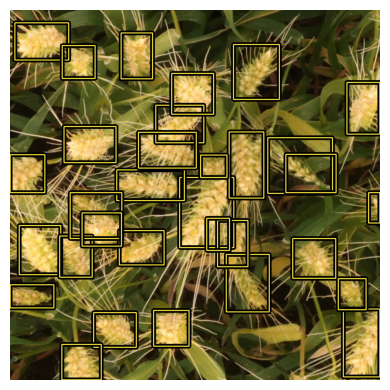

✅ Final WBF-Fused TTA Result visualized.


In [90]:
# Assuming you have the fused result from wbf_and_format:
# submission_string, y_pred_fused = wbf_and_format(...)

visualize_prediction(
    image_tensor=test_img, 
    predictions=y_pred_fused, 
    title="Final WBF-Fused TTA Result"
)

---
## **Section 8. Submission file and Test dataset**

This section handles **end-to-end inference** on the test dataset.  
It applies **Test-Time Augmentation (TTA)** and **Weighted Boxes Fusion (WBF)** for each image, formats predictions for Kaggle submission, and optionally visualizes results.  

The pipeline includes:
1. Preparing the test dataset.
2. Running TTA/WBF for each image.
3. Collecting results into a submission DataFrame.

---

### **8.1 Preprocessing Individual Test Images**

- **Function:** `preprocess_for_inference(image_path)`  
- **Purpose:** Loads a single image, resizes it to the model’s input shape, and extracts the image ID (filename without extension).  
- **Output:** `(image_tensor, image_id)` ready for inference.  

This ensures all test images are properly formatted for the model.

---

In [98]:
def preprocess_for_inference(image_path):
    """Loads and resizes a single image for model prediction."""
    image = load_single_test_image(image_path)
    image_id = tf.strings.split(image_path, os.sep)[-1]       # filename
    image_id = tf.strings.regex_replace(image_id, ".jpg$", "") # remove extension
    return image, image_id

### **8.2 Creating the Test Dataset**

- **Function:** `test_dataset(TEST_DIR)`  
- **Purpose:** Generates a `tf.data.Dataset` from all images in the test directory.  
- **Steps:** 
  - Collect image file paths.
  - Map each path through `preprocess_for_inference`.
  - Batch and prefetch for efficient GPU/CPU utilization.  
- **Output:** A TensorFlow dataset suitable for batch-wise TTA/WBF inference.

In [99]:
def test_dataset(TEST_DIR):
    '''Create dataset with loading all images in Test directory'''
    test_images_path = [
        os.path.join(TEST_DIR, fname) for fname in os.listdir(TEST_DIR)
    ]
    test_ds = tf.data.Dataset.from_tensor_slices(test_images_path)
    test_ds = (test_ds.map(preprocess_for_inference, num_parallel_calls= AUTO)
                      .batch(BATCH_SIZE)
                      .prefetch(AUTO))
    
    print('Test Dataset created successfully !')
    return test_ds

### **8.3 Running TTA/WBF & Creating Submission File**

- **Function:** `create_submission_file(model, test_ds, tta_sequences, img_size, conf_threshold, iou_threshold)`  
- **Purpose:** Processes all test images, applies TTA, fuses predictions via WBF, and creates a Kaggle-compatible submission.  
- **Steps:**
  1. Loop over each image in the test dataset.
  2. Run TTA and aggregate predictions.
  3. Apply WBF to merge overlapping boxes and filter by confidence.
  4. Format predictions into Kaggle "conf xmin ymin w h" strings.
  5. Collect all image IDs and prediction strings into a DataFrame.
  6. Optionally visualize the first image’s fused predictions.  

- **Output:** `pd.DataFrame` containing `image_id` and `PredictionString`, ready for submission.

In [97]:
def create_submission_file(model, test_ds, tta_sequences, img_size, conf_threshold, iou_threshold):
    """
    Processes the entire test dataset using TTA/WBF and creates the submission DataFrame.
    
    Args:
        model: The Keras model.
        test_ds: The tf.data.Dataset for the test images.
        ... all other necessary parameters
        
    Returns:
        pd.DataFrame: The final submission dataframe.
    """
    submission_data = {"image_id": [], "PredictionString": []}
    
    print("\n=======================================================")
    print(">>> Starting Inference on Test Dataset with TTA/WBF <<<")
    print("=======================================================")
    
    # Iterate through the test dataset
    for step, (images, image_ids) in enumerate(test_ds):
        
        # Loop through images in the current batch (usually batch_size=1 for TTA)
        for image_tensor, image_id in zip(images, image_ids):
            
            image_id_str = image_id.numpy().decode('utf-8')
            print(f"\n[IMAGE {step+1}] Processing image: {image_id_str}")

            # 1. Run TTA and Aggregate
            all_boxes, all_confidences, all_classes = tta(
                model, image_tensor, tta_sequences, conf_threshold
            )
            
            if all_boxes is None:
                # No detections, prediction string is empty
                submission_string = ""
                y_pred_fused = None
            else:
                # 2. Run WBF and Format
                submission_string, y_pred_fused = wbf(
                    all_boxes, all_confidences, all_classes, 
                    img_size, conf_threshold, iou_threshold
                )
            
            # 3. Collect Result
            submission_data["image_id"].append(image_id_str)
            submission_data["PredictionString"].append(submission_string)

            # 4. Optional: Visualize the first image result
            if step == 1 and y_pred_fused is not None:
                visualize_prediction(image_tensor, 
                                     predictions=y_pred_fused, 
                                     title="Final WBF-Fused TTA Result")

    print("\n=======================================================")
    print(">>> TTA/WBF Inference Complete. Creating Submission File <<<")
    
    submission_df = pd.DataFrame(submission_data)
    return submission_df

In [100]:
test_ds = test_dataset(TEST_DIR)

Test Dataset created successfully !



>>> Starting Inference on Test Dataset with TTA/WBF <<<

[IMAGE 1] Processing image: 796707dd7
--- Running TTA for 1 image (7 sequences) ---
  > Sequence 1/7 (37 boxes) processed.
  > Sequence 2/7 (38 boxes) processed.
  > Sequence 3/7 (40 boxes) processed.
  > Sequence 4/7 (18 boxes) processed.
  > Sequence 5/7 (22 boxes) processed.
  > Sequence 6/7 (39 boxes) processed.
  > Sequence 7/7 (35 boxes) processed.
--- Aggregation Complete. Total boxes for WBF: 229 ---
--- WBF Applied. Boxes reduced to 31 before final filter. ---
--- Final 31 boxes remain after final confidence filter. ---
--- Submission String Example: 0.5543 675 455 106 128 0.5489 710 824 107 100 0.5337 784 529 162 185 0.5306 461 266 121 106 0.5116 5... ---

[IMAGE 2] Processing image: 2fd875eaa
--- Running TTA for 1 image (7 sequences) ---


/kaggle/input/wheat-detection-ensemble-boxes/isolated_ensemble_boxes/ensemble_boxes/ensemble_boxes_wbf.py:54: UserWarning: Y1 < 0 in box. Set it to 0.
  warnings.warn('Y1 < 0 in box. Set it to 0.')


  > Sequence 1/7 (44 boxes) processed.
  > Sequence 2/7 (49 boxes) processed.
  > Sequence 3/7 (39 boxes) processed.
  > Sequence 4/7 (52 boxes) processed.
  > Sequence 5/7 (49 boxes) processed.
  > Sequence 6/7 (52 boxes) processed.
  > Sequence 7/7 (50 boxes) processed.
--- Aggregation Complete. Total boxes for WBF: 335 ---
--- WBF Applied. Boxes reduced to 32 before final filter. ---
--- Final 32 boxes remain after final confidence filter. ---
--- Submission String Example: 0.6281 529 863 117 124 0.6247 946 651 77 95 0.6029 454 488 88 145 0.5950 463 351 125 99 0.5704 0 0 1... ---

--- Final WBF-Fused TTA Result ---


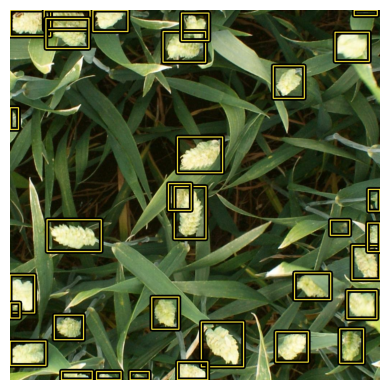

✅ Final WBF-Fused TTA Result visualized.

[IMAGE 3] Processing image: cc3532ff6
--- Running TTA for 1 image (7 sequences) ---
  > Sequence 1/7 (34 boxes) processed.
  > Sequence 2/7 (43 boxes) processed.
  > Sequence 3/7 (36 boxes) processed.
  > Sequence 4/7 (32 boxes) processed.
  > Sequence 5/7 (39 boxes) processed.
  > Sequence 6/7 (37 boxes) processed.
  > Sequence 7/7 (34 boxes) processed.
--- Aggregation Complete. Total boxes for WBF: 255 ---
--- WBF Applied. Boxes reduced to 30 before final filter. ---
--- Final 30 boxes remain after final confidence filter. ---
--- Submission String Example: 0.6319 0 405 158 108 0.6027 483 570 109 145 0.6012 765 823 172 166 0.5756 72 804 135 174 0.5695 265 ... ---

[IMAGE 4] Processing image: 53f253011
--- Running TTA for 1 image (7 sequences) ---
  > Sequence 1/7 (39 boxes) processed.
  > Sequence 2/7 (45 boxes) processed.
  > Sequence 3/7 (51 boxes) processed.
  > Sequence 4/7 (45 boxes) processed.
  > Sequence 5/7 (37 boxes) processed.
  > 

In [101]:
submission_df = create_submission_file(yolo_model,
                       test_ds,
                       TTA_SEQUENCES,
                       IMG_SIZE,
                       CONF_THRESHOLD,
                       IOU_THRESHOLD)

In [102]:
submission_df.head()

image_id                                   PredictionString
0  796707dd7  0.5543 675 455 106 128 0.5489 710 824 107 100 ...
1  2fd875eaa  0.6281 529 863 117 124 0.6247 946 651 77 95 0....
2  cc3532ff6  0.6319 0 405 158 108 0.6027 483 570 109 145 0....
3  53f253011  0.6121 618 95 126 152 0.6078 469 463 149 193 0...
4  f5a1f0358  0.5903 682 200 124 99 0.5856 445 293 113 196 0...

In [103]:
# Save the final submission file
submission_df.to_csv('submission.csv', index=False)

print('Submission file created successfully!')

Submission file created successfully!


# ✅ Conclusion

In this notebook, we implemented a **professional inference pipeline** for the Wheat Detection Kaggle competition. Key takeaways include:

- **Efficient preprocessing:** Test images are resized and prepared for model input, ensuring consistent tensor shapes.  
- **Test-Time Augmentation (TTA):** Horizontal, vertical flips and color jittering help improve prediction robustness.  
- **Weighted Boxes Fusion (WBF):** Aggregates predictions from multiple TTA variants, reducing duplicate boxes and improving localization accuracy.  
- **Submission-ready pipeline:** Predictions are converted into Kaggle-compatible format (`conf xmin ymin w h`) and stored in a DataFrame.  
- **Optional visualization:** Enables visual verification of predictions, helping debug or showcase model performance.

This modular design allows **easy extension** to new augmentations, different backbones, or updated models without modifying the core workflow.

---

# 📚 References

- **KerasCV YOLOv8 Documentation:** [KerasCV Object Detection Guide](https://keras.io/api/keras_cv/models/yolo/)  
  Provides guidance on **fine-tuning YOLOv8**, preprocessing images, handling bounding boxes, and visualization utilities.
